<a href="https://colab.research.google.com/github/kconstable/market_predictions/blob/main/market_data_av.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [68]:
# import sys
# !{sys.executable} -m pip install plotly

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import pickle
import re
from datetime import date, timedelta,datetime
from tabulate import tabulate
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from google.colab import files

# alphavalue key
key = '2Y4KISB4XMRRRPW7'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cypto Currencies

In [3]:
def get_crypto_intraday(symbol,key,interval='60min',outputsize='compact',market='USD'):
  """
  CRYPTO_INTRADAY
    symbol: DOGE, BTC, ETH
    key: apikey
    interval: 1min, 5min, 15min, 30min, 60min
    outputsize: compact(last 100), full (all)
    market: USD
  """

  # build query string, get data as json and convert to a dict
  url = f"https://www.alphavantage.co/query?function=CRYPTO_INTRADAY&symbol={symbol}&market={market}&interval={interval}&outputsize={outputsize}&apikey={key}"
  r = requests.get(url)
  d = r.json()

  # extract data to df
  df=pd.DataFrame(d[f'Time Series Crypto ({interval})']).T
  df.columns = ['open','high','low','close','volume']
  df['symbol'] = d['Meta Data']['2. Digital Currency Code']
  df['name'] = d['Meta Data']['3. Digital Currency Name']

  return df

In [4]:
# def get_crypto_data(symbol,key):
#   """
#   'ETH', 'BTC', 'DOGE'
#   """
#   # build query string, get data as json and convert to a dict
#   url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market=CAD&apikey={key}'
#   r = requests.get(url)
#   d = r.json()

#   # extract data to df
#   df=pd.DataFrame(d['Time Series (Digital Currency Daily)']).T

#   # remove columns not required
#   # returns the price in two currencies, just keep USD
#   cols = [c for c in df.columns if '(CAD)' not in c]
#   df=df.loc[:, cols]
#   df.columns = ['open','high','low','close','volume','marketcap']

#   # add the cyrpto name
#   df['name'] = d['Meta Data']['3. Digital Currency Name']

#   return df


## Stocks

In [3]:
def get_ticker_data(symbol,key,outputsize='compact',throttle=0):
  """
  Returns daily data for a stock (symbol)
    outputsize: compact(last 100) or full (20 years)
    key: apikey
    symbols: OILK (oil ETF),BAR(gold ETF),VXZ (volatility ETF)
  """
  url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={outputsize}&apikey={key}'
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # extract data to a df
  df = pd.DataFrame(d['Time Series (Daily)']).T
  df.columns = ['open','high','low','close','volume']
  df['symbol'] = d['Meta Data']['2. Symbol']

  # change data types
  df.index = pd.to_datetime(df.index)

  # convert datatype to float
  for col in ['open','high','low','close','volume']:
    df[col] = df[col].astype('float')

  # Calculate missing data
  missing = sum(df.close.isna())
  total = df.shape[0]
  missing_pct = round(missing/total*100,2)

  # Print the results
  summary = ['Ticker',symbol,str(total),str(missing),str(missing_pct)+'%','none']

  return {'summary':summary,'data':df}



## Economic Indicators

In [4]:
def get_economic_indicators(funct,key,interval=None,maturity=None,throttle=0):
  """
  Returns Economic Indicator Data with missing values interpolated between dates
  Monthly Data:
    NONFARM_PAYROLL, INFLATION_EXPECTATION,CONSUMER_SENTIMENT,UNEMPLOYMENT
  Daily, Weekly, Monthly Data:  
    FEDERAL_FUNDS_RATE = interval (daily,weekly,monthly)
    TREASURY_YIELD = interval (daily, weekly, monthly), 
                     maturity (3month, 5year, 10year, and 30year)
  """
  
  # query strings
  # Monthly Data:
  if funct in ['NONFARM_PAYROLL','INFLATION_EXPECTATION','CONSUMER_SENTIMENT','UNEMPLOYMENT']:
    url = f'https://www.alphavantage.co/query?function={funct}&apikey={key}'

  # Daily, Weekly or Monthly Data:
  # Interest Rates
  if funct == 'FEDERAL_FUNDS_RATE':
    url = f'https://www.alphavantage.co/query?function={funct}&interval={interval}&apikey={key}'

  # Treasury Yield  
  if funct == 'TREASURY_YIELD':
    url = f'https://www.alphavantage.co/query?function={funct}&interval={interval}&maturity={maturity}&apikey={key}'

  # pull data
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # convert to df
  df = pd.DataFrame(d['data'])

  # move date to a datetime index
  df.date = pd.to_datetime(df.date)
  df.set_index('date',inplace=True)

  # add the ticker name and frequency
  df['name'] = d['name']
  df['interval']=d['interval'] 

  # clean data & interpolate missing values
  # missing data encoded with '.'
  # change datatype to float
  df.replace('.',np.nan,inplace=True)
  df.value = df.value.astype('float')

  # missing data stats
  missing =sum(df.value.isna())
  total =df.shape[0]
  missing_pct = round(missing/total*100,2)

  # interpolate using the time index
  if missing >0:
    df.value.interpolate(method='time',inplace=True)
    action = 'interpolate'
  else:
    action = 'none'

  # Print the results
  if maturity is not None:
    summary = ['Economic Indicator',funct+':'+maturity,str(total),str(missing),str(missing_pct)+'%',action]
  else:
    summary = ['Economic Indicator',funct,str(total),str(missing),str(missing_pct)+'%',action]


  return {'summary':summary,'data':df}


## Technical Indicators

In [5]:
def get_technical_indicators(symbol,funct,key,interval,time_period=None,throttle=0):
  """
  Returns Technical Indicators (only works for stocks, not cyrpto)
  MACD:   symbol,interval
  RSI:    symbol,interval,time_period
  BBANDS: symbol,interval,time_period

  Parameters:
          interval: (1min, 5min, 15min, 30min, 60min, daily, weekly, monthly)
          series_type: (open, close,high,low)-default to close
          timer_periods: Integer
  """
  # build the query string
  if funct =='MACD':
    url = f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&apikey={key}'
  if funct in ['RSI','BBANDS']:
    url = f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&time_period={time_period}&apikey={key}'

  # request data as json, convert to dict, pause request to avoid the data throttle
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # extract to a df, add the indicator name, convert the index to datetime
  df = pd.DataFrame(d[f'Technical Analysis: {funct}']).T
  df.index = pd.to_datetime(df.index)

  # convert the data to float
  for col in df.columns:
    df[col] = df[col].astype('float')

  # check for missing data
  missing = df.isnull().any().sum()
  total = len(df)
  missing_pct = round(missing/total*100,2)


  # Print the results
  summary=['Technical Indicator',funct,str(total),str(missing),str(missing_pct)+'%','none']

  return {'summary':summary,'data':df}


## Combine Stock Data
+ price data
+ economic
+ technical

Timestamp('2009-01-30 00:00:00')

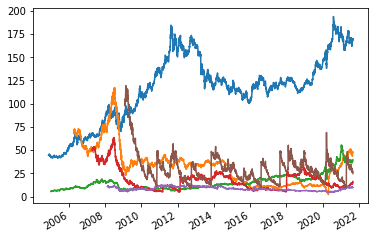

In [36]:
# gold=get_ticker_data('GLD',key,'full')
# blx = get_ticker_data('BLX.TO',key,'full')
# oil = get_ticker_data('USO',key,'full')
# gas = get_ticker_data('UNG',key,'full')
vol = get_ticker_data('VXX',key,'full')



gold['data']['close'].plot()
oil['data']['close'].plot()
blx['data']['close'].plot()
gas['data']['close'].plot()
bf['data']['close'].plot()
vol['data']['close'].plot()
vol['data'].index.min()

#         BLX.TO =  jan 2005
# gold:   GLD = nov 2004
# oil:    OIL = apr 2011,uso=apr 2006
# gas:    UNL = jan 2010, BOIL=oct 2011
# vol:    VXX = jan 2009


In [20]:
def get_consolidated_stock_data(symbol,key,config,outputsize='compact',throttle=5,dropna=True):
  """
  5 API requests per minute and 500 requests per day
  """

  # Result header and accumulator
  header = ['Type','Data','Total','Missing',' % ','Action']
  summary =[]

  # Get stock prices
  try:
    results  = get_ticker_data(symbol,key,outputsize,0)
    dff = results['data']
    summary.append(results['summary'])
    print(f'Complete:===>Ticker:{symbol}')
  except:
    print(f'Error:===>Ticker:{symbol}')



  # Get Commodity prices
  # ****************************************************************************
  for commodity in config['Commodities']:
    try:
      # get prices
      results = get_ticker_data(commodity,key,outputsize,throttle)
      df = results['data']
      summary.append(results['summary'])
      print(f'Complete:===>Commodity:{commodity}')


      # rename close to commodity name, remove unneeded columns and join with 
      # the stock prices by date
      df.rename(columns={'close':commodity},inplace=True)
      df.drop(['open','high','low','volume','symbol'],axis=1,inplace=True)
      dff = dff.join(df,how='left')
    except:
      print(f"Error===>Commodity:{commodity}")


  # Economic Indicators
  # ****************************************************************************
  # loop through the config to pull the requested data
  for indicator,values in config['Economic'].items():
    if indicator == 'TREASURY_YIELD':
      for tr in values:
        try:
          results = get_economic_indicators(indicator,key,interval=tr['interval'],maturity=tr['maturity'],throttle=throttle)
          summary.append(results['summary'])
          print(f"Complete===>{indicator}:{tr['maturity']}")

          df = results['data']
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": tr['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}:{tr['maturity']}")
   
    else: 
      # daily
      if values['interval']=='daily':
        try:
          results = get_economic_indicators(indicator,key,interval=values['interval'],throttle=throttle)
          df = results['data']
          summary.append(results['summary'])
          print(f"Complete===>{indicator}")

          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")
  
      else: 
        try:
          # monthly or weekly
          results = get_economic_indicators(indicator,key,throttle=throttle)
          summary.append(results['summary'])
          df = results['data']
          print(f"Complete===>{indicator}")

          # reindex to daily, fill missing values forward
          days = pd.date_range(start = min(df.index),end =max(df.index),freq='D')
          df =df.reindex(days,method = 'ffill')
      
          # join with the other data
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")

  # # Technical Indicators
  # ****************************************************************************
  for indicator,values in config['Technical'].items():
    try:
      results = get_technical_indicators(symbol,indicator,key,values['interval'],values['time_period'],throttle)
      df = results['data']
      summary.append(results['summary'])

      dff = dff.join(df,how='left')
      print(f"Complete===>{indicator}")
    except:
      print(f"Error===>{indicator}")

  
  # clean column names
  dff.rename(columns={"Real Upper Band":'b-upper',
                      "Real Lower Band":'b-lower',
                      "Real Middle Band":"b-middle",
                      "RSI":"rsi",
                      "MACD_Hist":"macd_hist",
                      "MACD_Signal":"macd_signal",
                      "MACD":"macd"
                      },inplace=True)
      

  # Fill in any missing data after joining all datasets
  dff.fillna(method='bfill',inplace=True,axis = 0)

  # drop rows with missing commodity prices
  if dropna:
    dff.dropna(how='any',inplace=True)

  # print the results table
  print("\n\n")
  print(tabulate(summary,header))

  return dff

In [22]:
# Get Consolidated Data
# https://etfdb.com/
# stock:  BLX.TO =  jan 2005
# gold:   GLD = nov 2004
# oil:    OIL = apr 2011, USO=apr 2006
# gas:    UNL = jan 2010, BOIL=oct 2011
# vol:    VXX = jan 2009

config ={'Economic':
         {'TREASURY_YIELD':[{'interval':'daily','maturity':'5year','name':'yield5y'},
                            {'interval':'daily','maturity':'10year','name':'yield10y'},
                            {'interval':'daily','maturity':'30year','name':'yield30y'}
                            ],
          'FEDERAL_FUNDS_RATE':{'interval':'daily','name':'ir'},
          'NONFARM_PAYROLL':{'interval':'monthly','name':'nfp'},
          'UNEMPLOYMENT':{'interval':'monthly','name':'unemployment'},
          'CONSUMER_SENTIMENT':{'interval':'monthly','name':'cs'},
          'INFLATION_EXPECTATION':{'interval':'monthly','name':'infl'},
          },
         'Technical':{
           'BBANDS':{'interval':'daily','time_period':20},
           'RSI':{'interval':'daily','time_period':20},
           'MACD':{'interval':'daily','time_period':20}
           },
         'Commodities':['GLD','OIL','VXX','BOIL']
         }

# compact, full
outputsize = 'full'
dff = get_consolidated_stock_data('BLX.TO',key,config,throttle=30,outputsize=outputsize,dropna=True)


# save to google drive
dff.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/market_data_{outputsize}.pickle')
dff.to_csv(f'/content/drive/MyDrive/Colab Notebooks/data/market_data_{outputsize}.csv')

# save to local drive
dff.to_pickle(f"market_data_{outputsize}.csv")
dff.to_csv(f'market_data_{outputsize}.pickle')
files.download(f"market_data_{outputsize}.csv")
files.download(f'market_data_{outputsize}.pickle')

Complete:===>Ticker:BLX.TO
Complete:===>Commodity:GLD
Complete:===>Commodity:OIL
Complete:===>Commodity:VXX
Complete:===>Commodity:BOIL
Complete===>TREASURY_YIELD:5year
Complete===>TREASURY_YIELD:10year
Complete===>TREASURY_YIELD:30year
Complete===>FEDERAL_FUNDS_RATE
Complete===>NONFARM_PAYROLL
Complete===>UNEMPLOYMENT
Complete===>CONSUMER_SENTIMENT
Complete===>INFLATION_EXPECTATION
Complete===>BBANDS
Complete===>RSI
Complete===>MACD



Type                 Data                     Total    Missing   %      Action
-------------------  ---------------------  -------  ---------  ------  -----------
Ticker               BLX.TO                    4179          0  0.0%    none
Ticker               GLD                       4226          0  0.0%    none
Ticker               OIL                       2609          0  0.0%    none
Ticker               VXX                       3170          0  0.0%    none
Ticker               BOIL                      2493          0  0.0%    none
Economic In

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(2484, 25)
2011-10-06 00:00:00


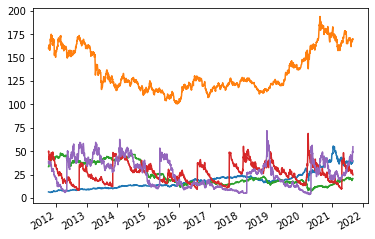

In [23]:
print(dff.shape)
print(dff.index.min())
dff.close.plot()
dff.GLD.plot()
dff.OIL.plot()
dff.VXX.plot()
dff.BOIL.plot()


## Save Files to Local

In [120]:
# upload files from local
# uploaded = files.upload()

df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/data/market_data_full.pickle')
# df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/data/market_data_compact.pickle')


## Visualizations
+ Candlestick Plots + Economic Indicators
+ Technical Indicators + Interest Rates
+ Correlations between Features

In [9]:
def plot_candlestick(df,yearfrom=None):
    """
    
    """

    # get ticker name
    name = df.symbol.unique()[0]

    # filter by year if provided
    if yearfrom is not None:
      df = df[df.index.year >= yearfrom]
    
    # Create subplots
    fig = make_subplots(rows=6, cols=1, 
                        shared_xaxes=True, 
                        subplot_titles=('Prices: Open/High/Low/Close','Volume','Non-Farm Payroll','Consumer Sentiment','Expected Inflation','Unemployment'),
                        vertical_spacing=0.07)
                   
    # OHLC Plot
    fig.add_trace(go.Candlestick(x=df.index, open=df.open, high=df.high,low=df.low, close=df.close, 
                name="Price",
                increasing_line_color= '#42BDA0', 
                decreasing_line_color= '#BD425F'), 
                row=1, col=1)
    
    
    # area chart for volume
    fig.add_trace(go.Scatter(x=df.index, y=df.volume, 
                fill='tozeroy',
                name='Volume',
                mode='none',
                fillcolor='rgba(156,189,66,.5)'),
                row=2,col=1)
    
    # Non-Farm Payrolls
    fig.add_trace(go.Scatter(x=df.index, y=df.nfp,name='Non-Farm Payroll',line_color='#BD425F'),
                  row=3,col=1)
    
    # Consumer Sentiment
    fig.add_trace(go.Scatter(x=df.index, y=df.cs,name='Consumer Sentiment',line_color='#42BDA0'),
                  row=4,col=1)

    # Expected Inflation    
    fig.add_trace(go.Scatter(x=df.index, y=df.infl,name='Expected Inflation',line_color='#6342BD'),
                  row=5,col=1)
    
    # Unemployment    
    fig.add_trace(go.Scatter(x=df.index, y=df.unemployment,name='Unemployment'),
                  row=6,col=1)

    # Do not show OHLC's rangeslider plot 
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.update_layout(template='plotly_white',
                      title = f"Price, Volume and Economic Indicators: {name}",
                      width = 1000,
                      height = 800)
          
    fig.show()

plot_candlestick(dff,2015)

In [10]:
def plot_technicals(df,yearfrom=None):
  """
  """

  # get the symbol name
  name = df.symbol.unique()[0]

  # filter by year if provided
  if yearfrom is not None:
    df = df[df.index.year >= yearfrom]


  # make subplots
  fig = make_subplots(rows=2, cols=2,
                      shared_xaxes=True,
                      subplot_titles = ('Bollinger Bands','MACD','RSI','Interest Rates'),
                      vertical_spacing = 0.07)

  # boolinger bands
  # ********************************************************************************************
  fig.add_trace(go.Scatter(x=df.index,y=df['b-upper'],name='Bollinger-Upper',line_color="#DFEBF9"),row=1,col=1)
  fig.add_trace(go.Scatter(x=df.index,y=df['b-lower'],name='Bollinger-Lower',line_color='#DFEBF9',fill='tonexty'),row=1,col=1)
  fig.add_trace(go.Scatter(x=df.index,y=df['b-middle'],name='Closing Price',line_color='#297AD6'),row=1,col=1)


  # MACD
  # ********************************************************************************************
  fig.add_trace(go.Scatter(x=df.index,y=df['macd'],name='MACD',line_color='#F7DAC6'),row=1,col=2)
  fig.add_trace(go.Scatter(x=df.index,y=df['macd_signal'],name='MACD Signal',line_color='#E68A4C'),row=1,col=2)
  fig.add_trace(go.Bar(x=dff.index,y=df['macd_hist'],name='MACD Hist',marker_color='#E06D1F', marker_line_color='#E06D1F'),row=1,col=2)


  # # RSI
  # ********************************************************************************************
  fig.add_trace(go.Scatter(x=df.index,y=df['rsi'],name='RSI',line_color='#F00F3C'),row=2,col=1)

  fig.update_yaxes(range=[0, 100],row=2,col=1)


  # Interest Rates
  # add Fed Rate, then loop through the df columns to add any feature that is a yield
  # ********************************************************************************************
  fig.add_trace(go.Scatter(x=df.index, y=df.ir,name='Fed Funds Rate',line_color='#4B9D0C'),row=2,col=2)
  colors = ['#C6CFC0','#306608','#310000']
  rate_cols = [c for c in df.columns if 'yield' in c]
  for i,rate in enumerate(rate_cols):
    # Extract the name of the yield
    name = 'Yield:'+re.findall(r'\d+', rate)[0]+' Year'
    fig.add_trace(go.Scatter(x=df.index, y=df[rate],name=name,line_color = colors[i]),row=2,col=2)


  # Set template
  fig.update_layout(template = 'plotly_white',width= 1000,height=800,title ='Technical Indicators & Yields')
  fig.show()


plot_technicals(dff,2021)

In [11]:
def plot_corr(df):
  """
  """
  # subset columns
  # remove redundent columns (only keep one price, and the signal for technical indicators)
  cols = [c for c in df.columns if c not in ['open','high','low','b-upper','b-lower','macd_hist','macd','symbol']]
          
  # calculate correlations
  cm =df[cols].corr()

  # plot a heatmap of correlations
  fig = go.Figure()
  fig.add_trace(go.Heatmap(
        z = cm,
        x = cm.columns.values,
        y = cm.columns.values,
        colorscale = 'Bluyl'
      )
  )
  fig.update_layout(
      title_text="Feature Correlations", 
      title_x=0.5, 
      width=500, 
      height=500,
      yaxis_autorange='reversed',
      template = 'plotly_white'
  )

  fig.show()

plot_corr(dff)